# Red Ocean Locator

In [21]:
# importing old libraries (also used in the two first parts)
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import requests
from bs4 import BeautifulSoup as bs
import folium
#from geopy.geocoders import Nominatim

## Postal Code of Amsterdam with coordinates

In [22]:
df = pd.read_excel('amsterdam-postcode1.xlsx')
df.head()

,OBJECTNUMMER,Postcode4,Neighbourhood,Opp_m2,COORDS,LNG,LAT
0,1,1011,Amsterdam-Noord,1467857,"POLYGON((4.856085 52.416656,4.859477 52.41976,...",4.866168,52.422284
1,2,1012,Petroleum,3286912,"POLYGON((4.82773 52.420777,4.828603 52.420673,...",4.843031,52.410937
2,5,1013,De Pijp,595621,"POLYGON((4.887389 52.360225,4.88766 52.360082,...",4.890788,52.354114
3,6,1014,Zuidelijke,1289497,"POLYGON((4.879225 52.364917,4.8801 52.365204,4...",4.891925,52.363208
4,7,1015,oostelijk Havengebied,3902815,"POLYGON((4.937355 52.382401,4.939831 52.382506...",4.935600,52.374593


In [23]:
amsterdam_dict = {'Postal Code':df['Postcode4'],'Neighbourhood':df['Neighbourhood'],'Longitude':df['LNG'],'Latitude':df['LAT']}
df_amsterdam = pd.DataFrame.from_dict(amsterdam_dict)
df_amsterdam.to_csv('amsterdam_part1.csv')

df_amsterdam.head()

,Postal Code,Neighbourhood,Longitude,Latitude
0,1011,Amsterdam-Noord,4.866168,52.422284
1,1012,Petroleum,4.843031,52.410937
2,1013,De Pijp,4.890788,52.354114
3,1014,Zuidelijke,4.891925,52.363208
4,1015,oostelijk Havengebied,4.935600,52.374593


## Map of Amsterdam with all postal codes

In [24]:
# for the city Amsterdam, latitude and longtitude are manually extracted via google search 
amsterdam_latitude = 52.3680; amsterdam_longitude = 4.9036
map_amsterdam = folium.Map(location = [amsterdam_latitude, amsterdam_longitude], zoom_start = 10.7)

# add markers to map
for lat, lng, Postcode4, Neighbourhood in zip(df_amsterdam['Latitude'], df_amsterdam['Longitude'], df_amsterdam['Postal Code'], df_amsterdam['Neighbourhood']):
    label = '{},{}'.format(Postcode4, Neighbourhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius = 10,
        popup = label,
        color ='blue',
        fill = True,
        fill_color = '#3186cc',
        fill_opacity = 0.7).add_to(map_amsterdam)  
    

map_amsterdam

## Connecting to Foursquare and Testing Venue Data for Amsterdam

In [25]:
Client_ID = 'HT1KJ2IDOCYFAFPRGPRX11OWNQYJ0NA0RGS1KEERRM00UL10'
Client_Secret = 'L3R4Q5CDIESLJV4HKBODBVK04YELBEPNMCNRAP4PDTM5GLET'
# @hiddel_cell
Version = '20180605' 

In [26]:
LIMIT = 200
#radius = 100
url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&limit={}'.format(Client_ID, Client_Secret, amsterdam_latitude, amsterdam_longitude, Version, LIMIT)


In [27]:
results = requests.get(url).json()
#results

In [28]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [29]:
import json # library to handle JSON files
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

venues = results['response']['groups'][0]['items']  
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng','venue.location.postalCode']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 5 columns):
name          100 non-null object
categories    100 non-null object
lat           100 non-null float64
lng           100 non-null float64
postalCode    86 non-null object
dtypes: float64(2), object(3)
memory usage: 4.0+ KB


In [30]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

100 venues were returned by Foursquare.


## Retrieving venue data from all neighbourhoods of Amsterdam


In [31]:
def getNearbyVenues(names, latitudes, longitudes, postalCode, radius = 500):
    
    venues_list=[]
    for name, lat, lng, postalCode in zip(names, latitudes, longitudes, postalCode):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            Client_ID, 
            Client_Secret, 
            Version, 
            lat, 
            lng, 
            radius,
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng,
            postalCode,
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Neighbourhood Latitude', 
                  'Neighbourhood Longitude', 
                  'Postal Code',
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude',
                  'Venue Category']
    
    return(nearby_venues)

In [32]:
Amsterdam_venues = getNearbyVenues(names=df_amsterdam['Neighbourhood'],
                                   latitudes=df_amsterdam['Latitude'],
                                   longitudes=df_amsterdam['Longitude'],
                                   postalCode=df_amsterdam['Postal Code']
                                  )

Amsterdam-Noord
Petroleum
De Pijp
Zuidelijke
oostelijk Havengebied
Burgwallen
Westelijke Grachtengordel
Haarlemmerbuurt
Alfa Driehoek
Staatsliedenbuurt
Westerlijke Markanaal
Oud Oost
Indisch Buurt (westelijk deel/0
Watergraafsmeer
Watergraafsmeer
Oud Oost
Oud Oost
Rivierenbuurt
Willemspark
Overtoombuurt
Potjeswetering
Overtoomse Veld
Slotervaart
Osdorp
Osdorp
Slotervaart
Slotermeer
Kolenkitbuurt
Slotermeer
Geuzenveld
Lastage
Buitenvelder
Buitenvelder
Rivierenbuurt
Omval
Grachtengordel
Kinkerbuurt
Frederik Hendrikbuurt
Bos en Lommer
Westerlijke Markanaal
Vogelbuurt
Nieuwendam- Noord
Weesperbuurt
Bijlmer Centrum
Bullewijk
Holendrecht
Bijlmer oost
Bijlmer oost
Nellestein
Driemond
Van de Pekbuurt
Buitenvelder
Schinkel
Postbussen
Museumkwartier
Apollobuurt
Stadionbuurt
Teleport
Australienhaven
Australienhaven
Afrikahaven
Bloemenbuurt
Tuindorp
Tuindorp
Holysloot
Durgerdam
Zunderdorp
Molenwijk
Buiksloot
Indisch Buurt (oosterlijk deel)
Steigereiland
Haveneiland
Nieuwendam
Amsterdam-Noord
Tuind

In [33]:
Amsterdam_venues.head()

,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Postal Code,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Amsterdam-Noord,52.422284,4.866168,1011,Wegrestaurant De Coentunnel,52.422001,4.866227,Café
1,Amsterdam-Noord,52.422284,4.866168,1011,Modeoutlet,52.418360,4.867722,Women's Store
2,Amsterdam-Noord,52.422284,4.866168,1011,Amsterdam Farm Lodge,52.419428,4.871256,Bed & Breakfast
3,De Pijp,52.354114,4.890788,1013,Orontes,52.354676,4.888620,Mediterranean Restaurant
4,De Pijp,52.354114,4.890788,1013,Pho 91,52.355178,4.891185,Vietnamese Restaurant


In [34]:
Amsterdam_venues.groupby('Neighbourhood').count()

,Neighbourhood Latitude,Neighbourhood Longitude,Postal Code,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighbourhood,,,,,,,
Afrikahaven,5,5,5,5,5,5,5
Alfa Driehoek,9,9,9,9,9,9,9
Amsterdam-Noord,8,8,8,8,8,8,8
Apollobuurt,23,23,23,23,23,23,23
Australienhaven,6,6,6,6,6,6,6
Bijlmer Centrum,41,41,41,41,41,41,41
Bijlmer oost,15,15,15,15,15,15,15
Bloemenbuurt,24,24,24,24,24,24,24
Bos en Lommer,43,43,43,43,43,43,43


In [35]:
print('There are {} uniques categories.'.format(len(Amsterdam_venues['Venue Category'].unique())))
print('There are {} uniques neighbourhood.'.format(len(Amsterdam_venues['Neighbourhood'].unique())))

There are 268 uniques categories.
There are 58 uniques neighbourhood.


## Filtering out all restaurant venues 


In [36]:
print('There are {} uniques categories.'.format(len(Amsterdam_venues['Venue Category'].unique())))

print('Here is the list of different categories:')
list(Amsterdam_venues['Venue Category'].unique())

There are 268 uniques categories.
Here is the list of different categories:


['Café',
 "Women's Store",
 'Bed & Breakfast',
 'Mediterranean Restaurant',
 'Vietnamese Restaurant',
 'Coffee Shop',
 'Marijuana Dispensary',
 'Middle Eastern Restaurant',
 'Boutique',
 'Pizza Place',
 'Salad Place',
 'Bar',
 'Bagel Shop',
 'Donut Shop',
 'Indonesian Restaurant',
 'Hotel',
 'Accessories Store',
 'Japanese Restaurant',
 'Burger Joint',
 'Deli / Bodega',
 'Restaurant',
 'Indie Movie Theater',
 'Indian Restaurant',
 'Ice Cream Shop',
 'Ramen Restaurant',
 'Italian Restaurant',
 'Breakfast Spot',
 'Seafood Restaurant',
 'Wine Shop',
 'Scandinavian Restaurant',
 'Moroccan Restaurant',
 'Gourmet Shop',
 'Food Truck',
 'Friterie',
 'Arts & Crafts Store',
 'Greek Restaurant',
 'Market',
 'Wine Bar',
 'Toy / Game Store',
 'Bakery',
 'Food & Drink Shop',
 'South American Restaurant',
 'Vegetarian / Vegan Restaurant',
 'Cheese Shop',
 'Fish Market',
 'Chinese Restaurant',
 'Sushi Restaurant',
 'Comfort Food Restaurant',
 'Dessert Shop',
 'French Restaurant',
 'BBQ Joint',
 'Park

In [37]:
#Next three lines to identify the restaurant_list
restaurant = Amsterdam_venues[Amsterdam_venues['Venue Category'].str.contains("Restaurant")].reset_index(drop=True)
#print('There are {} uniques categories.'.format(len(restaurant['Venue Category'].unique())))
list(restaurant['Venue Category'].unique())

restaurant_list = [ 
    'Mediterranean Restaurant',
 'Vietnamese Restaurant',
 'Middle Eastern Restaurant',
 'Indonesian Restaurant',
 'Japanese Restaurant',
 'Restaurant',
 'Indian Restaurant',
 'Ramen Restaurant',
 'Italian Restaurant',
 'Seafood Restaurant',
 'Scandinavian Restaurant',
 'Moroccan Restaurant',
 'Greek Restaurant',
 'South American Restaurant',
 'Vegetarian / Vegan Restaurant',
 'Chinese Restaurant',
 'Sushi Restaurant',
 'Comfort Food Restaurant',
 'French Restaurant',
 'Thai Restaurant',
 'Falafel Restaurant',
 'Asian Restaurant',
 'Tapas Restaurant',
 'Argentinian Restaurant',
 'Turkish Restaurant',
 'Latin American Restaurant',
 'Mexican Restaurant',
 'Spanish Restaurant',
 'American Restaurant',
 'Tibetan Restaurant',
 'Fast Food Restaurant',
 'Fondue Restaurant',
 'Modern European Restaurant',
 'Caribbean Restaurant',
 'Dutch Restaurant',
 'African Restaurant',
 'North Indian Restaurant',
 'Australian Restaurant',
 'Eastern European Restaurant',
 'Portuguese Restaurant',
 'Ethiopian Restaurant',
 'Dumpling Restaurant',
 'Persian Restaurant',
 'Belgian Restaurant',
 'Brazilian Restaurant',
 'Kebab Restaurant',
 'Swiss Restaurant',
 'Malay Restaurant',
 'Korean Restaurant',
 'Empanada Restaurant',
 'Peruvian Restaurant',
 'Hawaiian Restaurant']
    

In [42]:
restaurant_geo_grouped = restaurant.groupby('Neighbourhood').mean().reset_index()
restaurant_geo_grouped.head(60)

,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Postal Code,Venue Latitude,Venue Longitude
0,Alfa Driehoek,52.393100,4.862575,1019.000000,52.392806,4.868827
1,Apollobuurt,52.345157,4.875791,1079.000000,52.343777,4.879163
2,Bijlmer Centrum,52.315310,4.954521,1063.000000,52.314077,4.952569
3,Bijlmer oost,52.323871,4.974214,1068.000000,52.322652,4.974041
4,Bloemenbuurt,52.396291,4.909152,1091.000000,52.395153,4.911783
5,Bos en Lommer,52.380258,4.853296,1058.000000,52.380163,4.852152
6,Buiksloot,52.408866,4.915754,1098.000000,52.408269,4.916056
7,Buitenvelder,52.330151,4.876678,1051.888889,52.331443,4.878081
8,Bullewijk,52.298747,4.950586,1064.000000,52.298590,4.948864
9,Burgwallen,52.374927,4.897117,1016.000000,52.375104,4.898234


## One Hot Encoding of the Restaurant

In [43]:
# one hot encoding
restaurant_onehot = pd.get_dummies(restaurant[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
restaurant_onehot['Neighbourhood'] = restaurant['Neighbourhood'] 

# move neighborhood column to the first column
fixed_columns = [restaurant_onehot.columns[-1]] + list(restaurant_onehot.columns[:-1])
restaurant_onehot = restaurant_onehot[fixed_columns]

restaurant_onehot.head()

,Neighbourhood,African Restaurant,American Restaurant,Argentinian Restaurant,Asian Restaurant,Australian Restaurant,Belgian Restaurant,Brazilian Restaurant,Caribbean Restaurant,Chinese Restaurant,...,South American Restaurant,Spanish Restaurant,Sushi Restaurant,Swiss Restaurant,Tapas Restaurant,Thai Restaurant,Tibetan Restaurant,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant
0,De Pijp,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,De Pijp,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,De Pijp,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,De Pijp,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,De Pijp,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [45]:
restaurant_grouped = restaurant_onehot.groupby('Neighbourhood').sum().reset_index()
restaurant_grouped.head()

,Neighbourhood,African Restaurant,American Restaurant,Argentinian Restaurant,Asian Restaurant,Australian Restaurant,Belgian Restaurant,Brazilian Restaurant,Caribbean Restaurant,Chinese Restaurant,...,South American Restaurant,Spanish Restaurant,Sushi Restaurant,Swiss Restaurant,Tapas Restaurant,Thai Restaurant,Tibetan Restaurant,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant
0,Alfa Driehoek,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Apollobuurt,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,Bijlmer Centrum,0,0,0,1,0,0,0,0,3,...,0,0,0,0,0,0,0,1,0,0
3,Bijlmer oost,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,1,0,0
4,Bloemenbuurt,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0


In [71]:
#adding Total restaurant column to dafaframe

feat_name_list = list(restaurant_grouped.columns)
restaurant_list1 = []


for counter, value in enumerate(feat_name_list):
    if value.find('Restaurant') != (-1):
        restaurant_list1.append(value)
        
restaurant_grouped['Total Restaurants'] = restaurant_grouped[restaurant_list1].sum(axis = 1)
#restaurant_grouped = restaurant_grouped.drop(columns = restaurant_list1)

restaurant_grouped.head(26)

,Neighbourhood,African Restaurant,American Restaurant,Argentinian Restaurant,Asian Restaurant,Australian Restaurant,Belgian Restaurant,Brazilian Restaurant,Caribbean Restaurant,Chinese Restaurant,...,Sushi Restaurant,Swiss Restaurant,Tapas Restaurant,Thai Restaurant,Tibetan Restaurant,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Total Restaurants,Cluster Labels
0,Alfa Driehoek,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2,3
1,Apollobuurt,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,6,3
2,Bijlmer Centrum,0,0,0,1,0,0,0,0,3,...,0,0,0,0,0,1,0,0,26,7
3,Bijlmer oost,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,6,3
4,Bloemenbuurt,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,1,0,0,8,3
5,Bos en Lommer,0,0,0,0,0,0,0,0,0,...,1,0,0,1,0,1,2,0,20,7
6,Buiksloot,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,4,3
7,Buitenvelder,0,0,0,1,0,0,0,0,0,...,1,0,0,0,0,0,0,1,18,7
8,Bullewijk,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,10,3
9,Burgwallen,0,1,1,0,0,0,0,0,2,...,1,0,0,2,1,0,0,0,34,4


## Evaluating most efficient number of clusters 

For n_clusters = 2 The average silhouette_score is : 0.627648748611
For n_clusters = 3 The average silhouette_score is : 0.599210934283
For n_clusters = 4 The average silhouette_score is : 0.397348325816
For n_clusters = 5 The average silhouette_score is : 0.369224045012
For n_clusters = 6 The average silhouette_score is : 0.371709894613
For n_clusters = 7 The average silhouette_score is : 0.342984421402
For n_clusters = 8 The average silhouette_score is : 0.352044030736
For n_clusters = 9 The average silhouette_score is : 0.213705087699


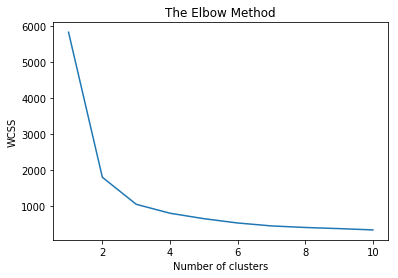

In [50]:
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
from graphviz import Graph
%matplotlib inline
#matrix = data.as_matrix()

restaurant_grouped_clustering = restaurant_grouped.drop('Neighbourhood', 1)
#restaurant_grouped_clustering.head()

for n_clusters in range(2,10):
    kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=30)
    kmeans.fit(restaurant_grouped_clustering)
    clusters = kmeans.predict(restaurant_grouped_clustering)
    silhouette_avg = silhouette_score(restaurant_grouped_clustering, clusters)
    print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)

from sklearn.cluster import KMeans
wcss = []
for i in range(1,11):
    kmeans = KMeans(n_clusters=i,init='k-means++',max_iter=300,n_init=10,random_state=0)
    kmeans.fit(restaurant_grouped_clustering)
    wcss.append(kmeans.inertia_)
plt.plot(range(1,11),wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

## Clustering neighbourhood to identify Red Ocean

In [72]:
# import k-means for clustering stage
from sklearn.cluster import KMeans

# set number of clusters
kclusters = 3

restaurant_grouped_clustering = restaurant_grouped.drop('Neighbourhood', 1)
#restaurant_grouped_clustering.head()

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(restaurant_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:58] 
#kmeans.cluster_centers_[0:5]
#len(kmeans.labels_)#=16


array([1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 0, 2, 2, 1, 1, 2, 0, 1, 2, 2, 1, 1, 1,
       1, 0, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 2, 1])

In [73]:
restaurant_grouped_clustering.head()

,African Restaurant,American Restaurant,Argentinian Restaurant,Asian Restaurant,Australian Restaurant,Belgian Restaurant,Brazilian Restaurant,Caribbean Restaurant,Chinese Restaurant,Comfort Food Restaurant,...,Sushi Restaurant,Swiss Restaurant,Tapas Restaurant,Thai Restaurant,Tibetan Restaurant,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Total Restaurants,Cluster Labels
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2,3
1,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,6,3
2,0,0,0,1,0,0,0,0,3,0,...,0,0,0,0,0,1,0,0,26,7
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,6,3
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,1,0,0,8,3


In [74]:
# merge restaurant_merged with restaurant_grouped to add total restaurant for each neighborhood
restaurant_merged = restaurant_grouped

# add clustering labels
restaurant_merged['Cluster Labels'] = kmeans.labels_

restaurant_merged.head()

,Neighbourhood,African Restaurant,American Restaurant,Argentinian Restaurant,Asian Restaurant,Australian Restaurant,Belgian Restaurant,Brazilian Restaurant,Caribbean Restaurant,Chinese Restaurant,...,Sushi Restaurant,Swiss Restaurant,Tapas Restaurant,Thai Restaurant,Tibetan Restaurant,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Total Restaurants,Cluster Labels
0,Alfa Driehoek,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2,1
1,Apollobuurt,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,6,1
2,Bijlmer Centrum,0,0,0,1,0,0,0,0,3,...,0,0,0,0,0,1,0,0,26,1
3,Bijlmer oost,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,6,1
4,Bloemenbuurt,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,1,0,0,8,1


In [96]:
# adding latitude/longitude for each neighborhood
result_restaurant = pd.merge(restaurant_merged,restaurant_geo_grouped, on='Neighbourhood')
result_restaurant.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44 entries, 0 to 43
Data columns (total 60 columns):
Neighbourhood                    44 non-null object
African Restaurant               44 non-null uint8
American Restaurant              44 non-null uint8
Argentinian Restaurant           44 non-null uint8
Asian Restaurant                 44 non-null uint8
Australian Restaurant            44 non-null uint8
Belgian Restaurant               44 non-null uint8
Brazilian Restaurant             44 non-null uint8
Caribbean Restaurant             44 non-null uint8
Chinese Restaurant               44 non-null uint8
Comfort Food Restaurant          44 non-null uint8
Dumpling Restaurant              44 non-null uint8
Dutch Restaurant                 44 non-null uint8
Eastern European Restaurant      44 non-null uint8
Empanada Restaurant              44 non-null uint8
Ethiopian Restaurant             44 non-null uint8
Falafel Restaurant               44 non-null uint8
Fast Food Restaurant         

## Displaying Clusters on Amsterdam map

In [81]:
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# create map
map_clusters = folium.Map(location = [amsterdam_latitude, amsterdam_longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(n_clusters)
ys = [i+x+(i*x)**2 for i in range(n_clusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, cluster in zip(result_restaurant['Neighbourhood Latitude'], result_restaurant['Neighbourhood Longitude'], result_restaurant['Cluster Labels']):
    label = folium.Popup(' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## Results and Decision Making

In [101]:
#on the map we can see that cluster #0 is pointing to the Red Ocean
#Following lines shows neighbourhood which are part of Cluster #0


result_restaurant.drop(result_restaurant.columns.difference(['Neighbourhood','Cluster Labels']), 1, inplace=True)
result_restaurant[result_restaurant['Cluster Labels'] == 0]

,Neighbourhood,Cluster Labels
10,De Pijp,0
16,Kinkerbuurt,0
24,Oud Oost,0


## Based on the machine learning output, we would advise these investors to look for a location  in De Pijp, Kinkerbuurt and Oud Oost (Cluster #0) where there is the highest concentration of restaurants and then of course to choose for a different type of food service offering … to go into the blue ocean !